# Car data processing

### Here fill storm name:

In [1]:
#storm_name = '2020/0413_bourka_NovohradskeHory'
#storm_name = '2020/0428_bourka_chotoviny'
#storm_name = '2020/0504_bourka_chotoviny'
storm_name = '2020/0511_bourka_veseli'

BLITZ_DIST = 30  # Distance in [km] from car position taking on to account

## Prerequisites

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from datetime import timezone
import datetime as dt
import json
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
#%pylab inline --no-import-all
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import time
os.environ['TZ'] = 'UTC'
time.tzset()


hdr_t = np.dtype([
    ('magic', 'u4'),
    ('id', 'u4'),
    ('timestamp', 'u4'),
    ('gps_flags', 'u1'),
    ('gps_sat', 'u1'),
    ('gps_lat', 'f4'),
    ('gps_long', 'f4'),
    ('gps_alt', 'u2'),
    ('gps_hour', 'u1'),
    ('gps_min', 'u1'),
    ('gps_sec', 'u1'),
    ('num_energy_data', 'u2'),
], align=True)

energy_data_t = np.dtype([
    ('info', 'u1'),
    ('timestamp_us', 'u4'),
    ('energy', 'f4'),
], align=True)

def read_rt_dat_file(filename):
    ret_dtype = np.dtype([
        ('time', 'u4'),
        ('time_us', 'u4'),
        ('energy', 'f4'),
        ('info', 'u1'),
        ('gps_lat', 'f4'),
        ('gps_long', 'f4'),
        ('gps_alt', 'u2')
    ])
    
    ret = np.zeros(0, dtype=ret_dtype)
    pieces = []

    with open(filename, 'r') as f:
        while True:
            try:
                hdr = np.fromfile(f, dtype=hdr_t, count=1)[0]
            except IndexError:
                break
            if hdr['magic'] != 0xaaaabbbb:
                raise Exception('corrupted data, magic mismatch')
                
            energy_data = np.fromfile(f, dtype=energy_data_t, count=hdr['num_energy_data'])
            piece = np.zeros(len(energy_data), dtype=ret_dtype)
            piece['time'] = hdr['timestamp']
            piece['time_us'] = energy_data['timestamp_us']
            piece['energy'] = energy_data['energy']
            piece['info'] = energy_data['info']
            piece['gps_lat'] = hdr['gps_lat']
            piece['gps_long'] = hdr['gps_long']
            piece['gps_alt'] = hdr['gps_alt']
            pieces.append(piece)
    return np.concatenate(pieces)

## Read Logfile

In [3]:
dto = '/storage/experiments/' + storm_name + '/meteo/' #  File to Open
fto = dto + 'DATALOG.TXT'

print (fto)

l=[]
l.extend(range(0,20))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )
#df = pd.read_table(fto, sep=',', header=None,comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

#df.drop(df[df[0]=='$STROKE'].index, inplace=True)
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

sn = df.loc[df[0]=='$DIVISEK'][3]
print (sn[0])


/storage/experiments/2020/0511_bourka_veseli/meteo/DATALOG.TXT
1290c00806a20091302fa000a000004d


## Derive measurement runs in to separate files

In [4]:
try:
    os.makedirs(dto + 'output/')
except:
    pass

run = 0

runs = []
LatDD = np.nan
LonDD = np.nan
flag = 0
flagrun = 0


import re
def dm_to_sd(dm):
    '''
    Converts a geographic co-ordinate given in "degrees/minutes" dddmm.mmmm
    format (eg, "12319.943281" = 123 degrees, 19.943281 minutes) to a signed
    decimal (python float) format
    '''
    # '12319.943281'
    if dm == 'nan':
        return np.nan
    if not dm or dm == '0':
        return 0.
    d, m = re.match(r'^(\d+)(\d\d\.\d+)$', dm).groups()
    return float(d) + float(m) / 60


for i,r in df.iterrows():
    if (r[0] == '$DIVISEK'):
        run = run + 1
        date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
        time = 0
        timedelta = 0
        altitude = np.nan
        Lat = np.nan
        Lon = np.nan
        speed = np.nan
        timeoffset = np.nan
        flag = 0
        flagrun = 0
        print (run,end='')
        
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        timedelta = time
        speed = r[7]
        if (r.astype(str)[4]=='S'):     # Conferr DDMM.MM to DD.DD
            LatS = -1
        else:
            LatS = 1
        if (r.astype(str)[6]=='W'):
            LonS = -1
        else:
            LonS = 1
        LatDD = dm_to_sd(str(r[3]))
        LatDD = LatDD * LatS  
        LonDD = dm_to_sd(str(r[5]))
        LonDD = LonDD * LonS 
        if (str(r[2]) == 'A'): 
            flag = 1
            
       
    if (r[0] == '$GPGGA'):
        altitude = r[9]

    df.at[i,'date'] = date
    df.at[i,'altitude'] = altitude
    df.at[i,'speed'] = speed

    if (r[0] == '$TIME'):
        timeoffset = pd.to_numeric(r[1])
        
    if (r[0] == '$MPL'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta,altitude,LatDD,LonDD])
                flagrun = 1
            flag = 0
        #date_line = date + pd.to_timedelta(time - timeoffset - timedelta, unit='s')
        date_line = date + pd.to_timedelta(time - timeoffset, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD
        df.at[i,'alt'] = altitude
        
        
    if (r[0] == '$STROKE'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
        date_line = date + pd.to_timedelta(time - timeoffset, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD
        df.at[i,'alt'] = altitude
                
print()

df = df[pd.notnull(df['date'])]
dfo = df.copy()
#dfo.reset_index(inplace=True)
dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$DIVISEK'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$TIME'].index, inplace=True)

for f in glob.iglob(dto + 'output/*.csv'): # delete all output files 
    print ('Deleting', f)
    os.remove(f)

for f in glob.iglob(dto + 'output/*.blitz'): # delete all output files 
    print ('Deleting', f)
    os.remove(f)

dfo.set_index('date', inplace = True)
l=[]
l.extend(range(6, 20))
dfo.drop(l, axis=1)

for x in runs: 
    dfo.loc[dfo['run'] == x[0]].to_csv(dto + 'output/' + str(x[3]) + '_' + str(x[4]) + '_' + str(x[5]) + '_' +  str(x[1] + pd.to_timedelta(-x[2], unit='s')) + '_' + str(sn[0]) + '.csv')   
    lat=dfo.loc[dfo['run'] == x[0]]['lat'][-1]
    lon=dfo.loc[dfo['run'] == x[0]]['lon'][-1]
    region=1
    start=dfo.loc[dfo['run'] == x[0]].index[0]
    end=dfo.loc[dfo['run'] == x[0]].index[-1]
    print(start, end, lat, lon)

    ### url for json data preparation
    url=[]
    for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
        next=start+ pd.Timedelta(minutes=i*10)
        url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))
    
    import requests
    blitz=pd.DataFrame()
    for i in range(len(url)):
        try:
            html = requests.get(url[i]).content
            blitz_part = pd.read_json(html,lines=True)
            blitz_part.drop(columns=['status','sig'], inplace=True)#,'region', 
            blitz=blitz.append(blitz_part)
        except:
            print("No data", url[i])
    blitz.set_index(['time'], inplace=True)
    
    ### reduction of too distant events
    blitz=blitz[(blitz['lat']>(lat-1) )&(blitz['lat']<(lat+1) )]
    blitz=blitz[(blitz['lon']>(lon-1) )&(blitz['lon']<(lon+1) )]
    ### calculation of distance of events from station
    #from math import radians, cos, sin, asin, sqrt, atan2, degrees

    #with pandas
    blitz['lonRad']=np.radians(blitz.lon)
    blitz['latRad']=np.radians(blitz.lat)
    lonRad=np.radians(lon)
    latRad=np.radians(lat)
    blitz['DlonRad']=lonRad-blitz.lonRad
    blitz['DlatRad']=latRad-blitz.latRad
    blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
    blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
    blitz.drop(columns=['lonRad','latRad','DlonRad','DlatRad','a'], inplace=True)
    try:
        blitz.drop(columns=['alt','pol','region'], inplace=True)
    except:
        print('No columns to drop (alt, pol, region)')
    #blitz['time']=blitz.index    
    blitz = blitz.loc[blitz['km'] < BLITZ_DIST]
    blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
    blitz.reset_index(inplace=True)
    blitz.set_index('date', inplace=True)
    
    blitz.to_csv(dto + 'output/' + str(x[3]) + '_' + str(x[4]) + '_' + str(x[5]) + '_' +  str(x[1] + pd.to_timedelta(-x[2], unit='s')) + '_' + str(sn[0]) + '.blitz')   

    
print('End')

1234
Deleting /storage/experiments/2020/0511_bourka_veseli/meteo/output/484.8_49.473816666666664_14.658034_2020-05-09 18:51:47_1290c00806a20091302fa000a000004d.csv
2020-05-09 18:52:27 2020-05-09 19:18:03 49.473811 14.6580105
2020-05-10 11:47:12 2020-05-10 12:12:14 49.51844216666667 14.066562
2020-05-10 12:27:15 2020-05-10 12:57:07 49.5824115 14.072041666666667
2020-05-11 14:19:36 2020-05-11 17:27:10 49.17523 14.677353333333333
End


## Plot Lightning, Precipitation, Pressure, Temperature

In [ ]:
for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    try:
        s = f.split('/')

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$MPL'].index, inplace=True)
               
        fig, (ax1, ax6, ax5, ax2, ax3, ax4) = plt.subplots(nrows=6, sharex=True, figsize=(15,25))
        #fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(15,25))
        
        ax1.set_ylim(0,0)
        ax1.set_yticks([])
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==8]
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='stroke')
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==4]
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='spark')
        ax1.set_title(s[len(s)-1])
        #ax1.set_xlabel('UT')
        ax1.set_ylabel('Lightning')
        ax1.legend()
        ax1.grid()

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['3'] = pd.to_numeric(xx['3'])

        interval = '5T'
        xx = xx.resample(interval, label='right').sum()
        ax2.plot(xx['3'], drawstyle='steps-mid', label = interval + ' precipitation')
        #ax2.set_title(interval + ' - ' + s[len(s)-1])
        ax2.set_ylabel('Flips [-]')
        ax2.grid(b=True, which='major', color='grey', linestyle='-')
        ax2.locator_params(axis="y", integer=True, tight=True)
        ax2.legend()
        
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['4'] = pd.to_numeric(xx['4'])
        xx['5'] = pd.to_numeric(xx['5'])

        ax3.plot(xx['4'])
        #plt.locator_params(axis='y', nbins=6)
        ax3.grid(b=True, which='major', color='grey', linestyle='-')

        #ax3.set_title(s[len(s)-1])
        #ax3.set_xlabel('UT')
        ax3.set_ylabel('Pressure')
        #plt.legend(loc=2)

        ax4.plot(xx['5'])
        ax4.set_xlabel('UT')
        ax4.set_ylabel('Temperature')
        #plt.autoscale()       
        ax4.grid(b=True, which='major', color='grey', linestyle='-')
        #plt.grid(b=True, which='minor', color='grey', linestyle='-')
        #plt.legend()
        
        rto = '/storage/experiments/' + storm_name 
        d = read_rt_dat_file(rto + '/RT/data.dat')
        import matplotlib.dates as md
        import matplotlib

        emin = 1
        emax = 1300
        
        tmin = int(xx.index.min().replace(tzinfo=timezone.utc).timestamp())
        tmax = int(xx.index.max().replace(tzinfo=timezone.utc).timestamp())

        nhits, time = np.histogram(d[(d['energy'] > emin) & (d['energy'] < emax)]['time'], tmax-tmin, [tmin, tmax])

        WINDOW = 30
        dfrt = pd.DataFrame(index=time[:-1],data=nhits)
        dfrt.dropna(axis=0, how='any', inplace = True)
        dfrt = dfrt.loc[dfrt[0]>0]
        dfrt['time'] = pd.to_datetime(dfrt.index, unit='s')
        dfrt.reset_index(inplace=True)
        dfrt.set_index('time',inplace=True)
        dfrt['avg'] = dfrt[0].rolling(WINDOW).mean()

        ax5.set_ylabel('Counts ($s^{-1}$)')
        ax5.set_xlabel('UT')
        ax5.plot(dfrt[0],ls='',alpha=130,marker='.',label='RT')
        ax5.plot(dfrt['avg'],lw=3,label='avg')
        #ax5.set_ylim(500,770)
        ax5.legend()
        ax5.set_yscale('log')
        ax5.grid()
        
        
        df7 = pd.read_csv(f[:-3]+'blitz')
        df7['date'] = pd.to_datetime(df7['time'], unit='ns')
        #df7.set_index('date', inplace=True)
        ax6.plot(df7.date, df7.km, ls='', marker='o', label='Blitzortung')
        ax6.set_ylabel('Distance [km]')
        ax6.legend()
        ax6.grid()
        
    except:
        pass



/nix/store/bzbi2yq42fzsi1p0jb86pj9wq4mbapc4-python3.7-ipykernel-5.1.4/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  del sys.path[0]


# Plot Map

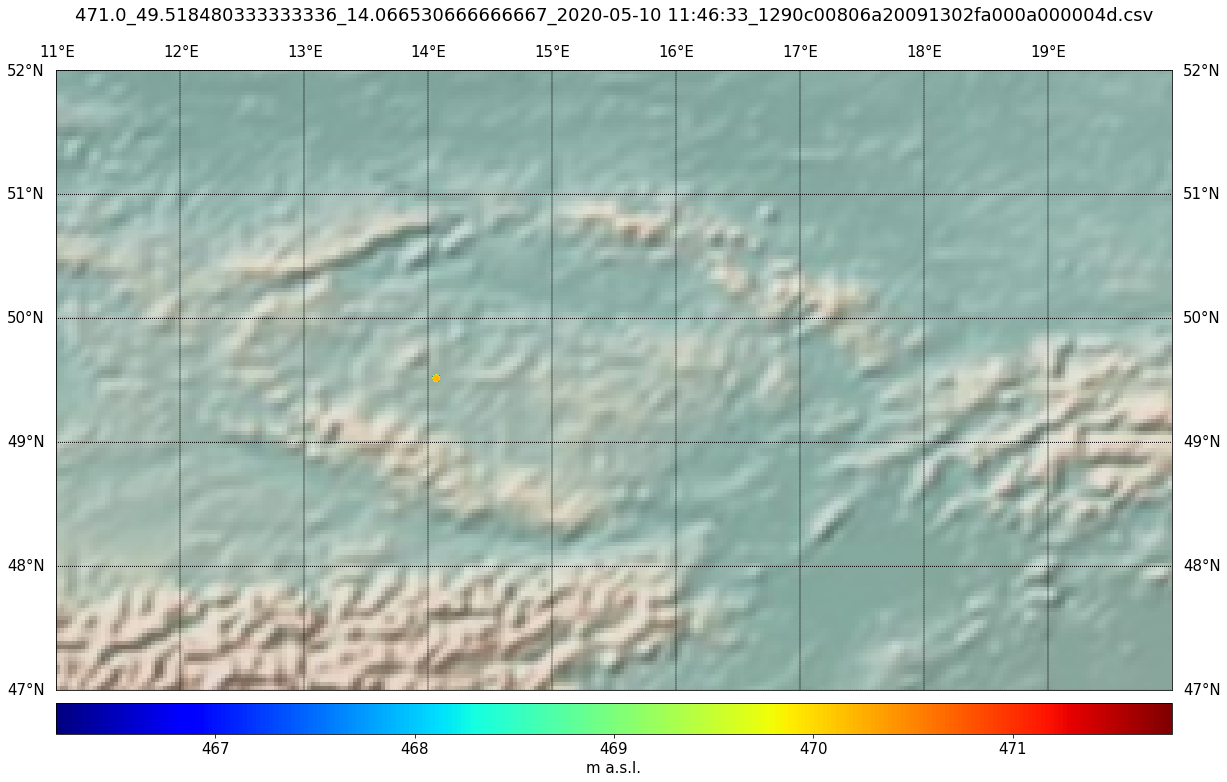

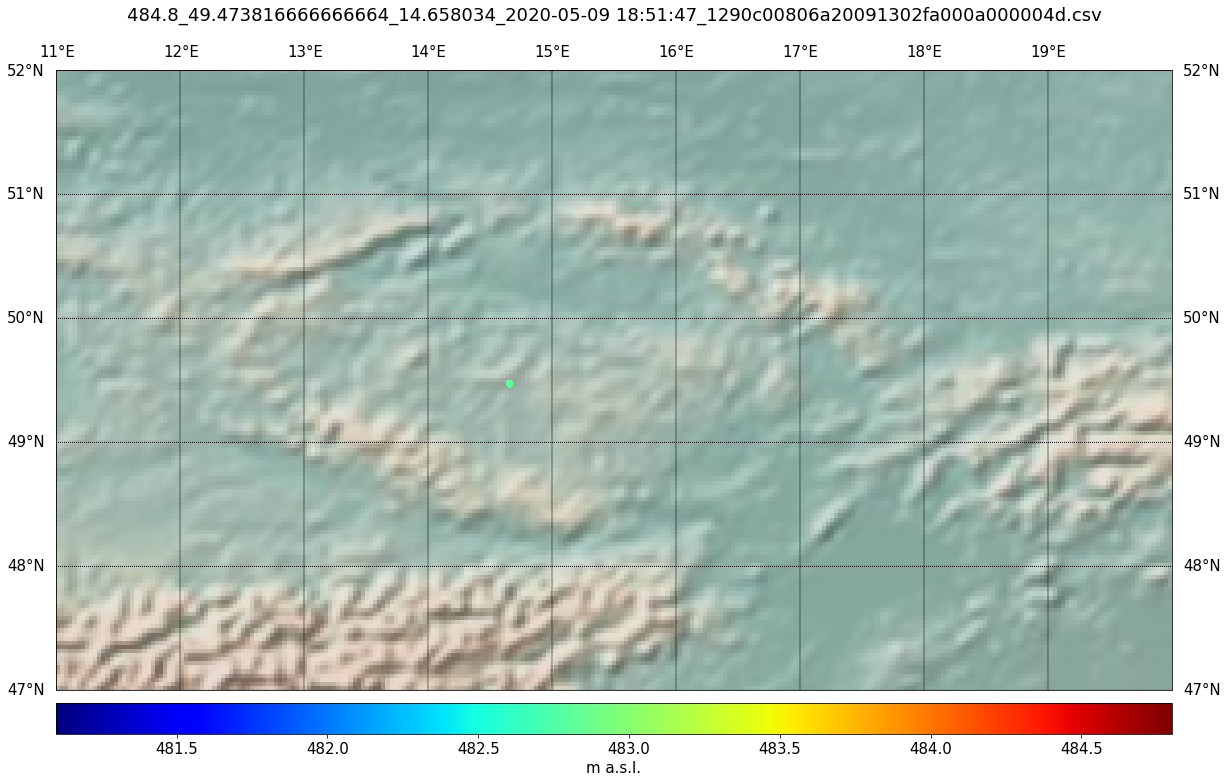

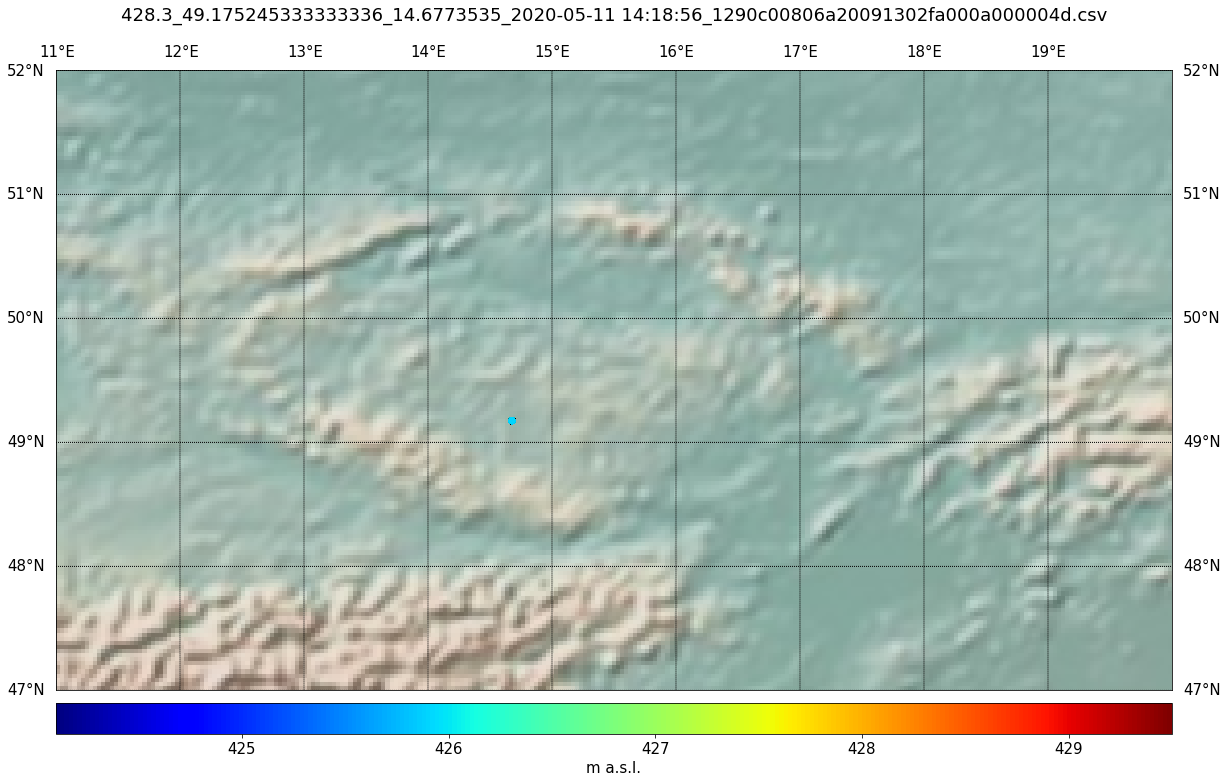

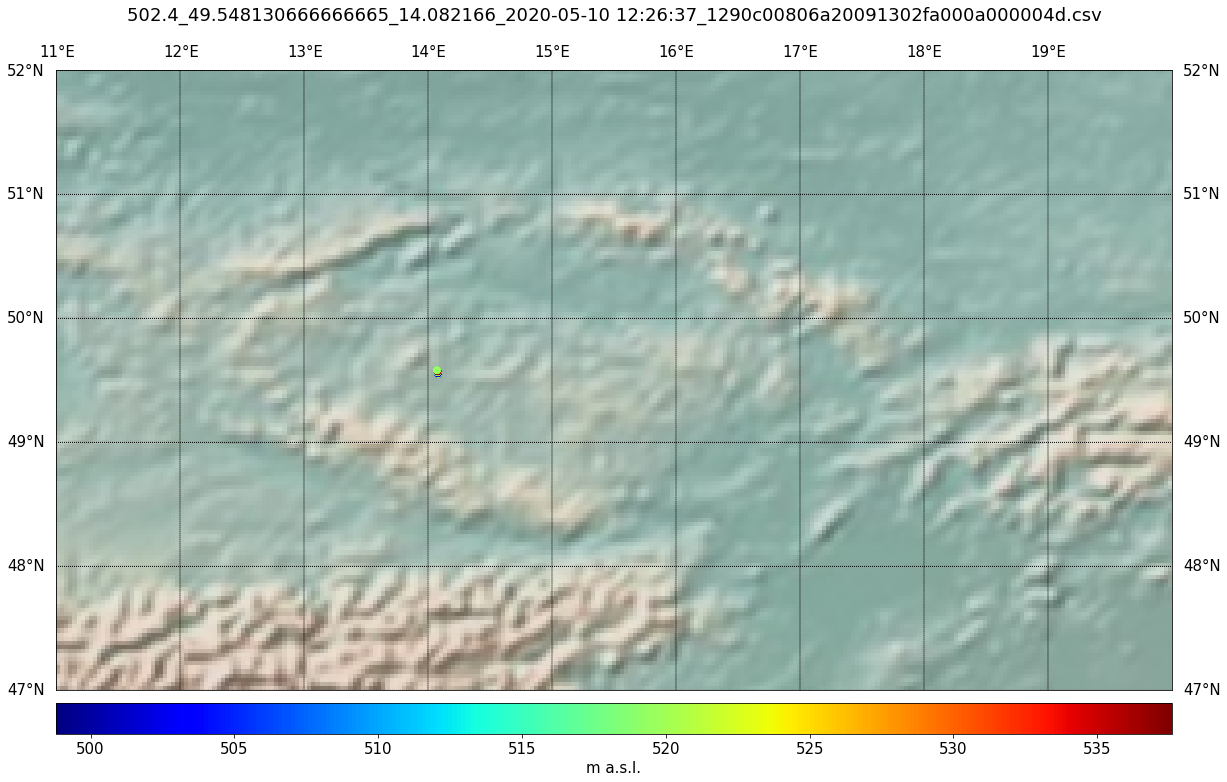

In [258]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import urllib, os

for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    #try:
        plt.figure(figsize=(20,20))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        #df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
        
        matplotlib.rcParams.update({'font.size': 15})

        # create Basemap instance.
        #m = Basemap(projection='kav7',lon_0=0)
        m = Basemap(projection='cyl',lon_0=0, llcrnrlon=11,llcrnrlat=47,urcrnrlon=20,urcrnrlat=52)
        #m = Basemap(projection='robin',lon_0=0)
        #m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

        x, y = m(df6.lon.tolist(),df6.lat.tolist())
        #m.drawmapboundary(fill_color='#99ffff')
        #m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
        # draw parallels and meridians, but don't bother labelling them.
        m.drawparallels(np.arange(0.,99.,1.),labels=[1,1,0,0])
        m.drawmeridians(np.arange(0.,20.,1.),labels=[0,0,1,0])
        m.shadedrelief()
        
        im1 = m.scatter(x,y,c=df6.altitude.tolist(),marker='o', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('m a.s.l.')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        #plt.clim(0, 12500)  # limit for color axis
        plt.show()                
    #except:
    #    pass


## Plot Street Map

49.51844216666667   14.066562
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1556976.95978855,6323937.32782448,1574788.0783154736,6337616.152785922&bboxSR=3395&imageSR=3395&size=1000,767&dpi=96&format=png32&transparent=true&f=image


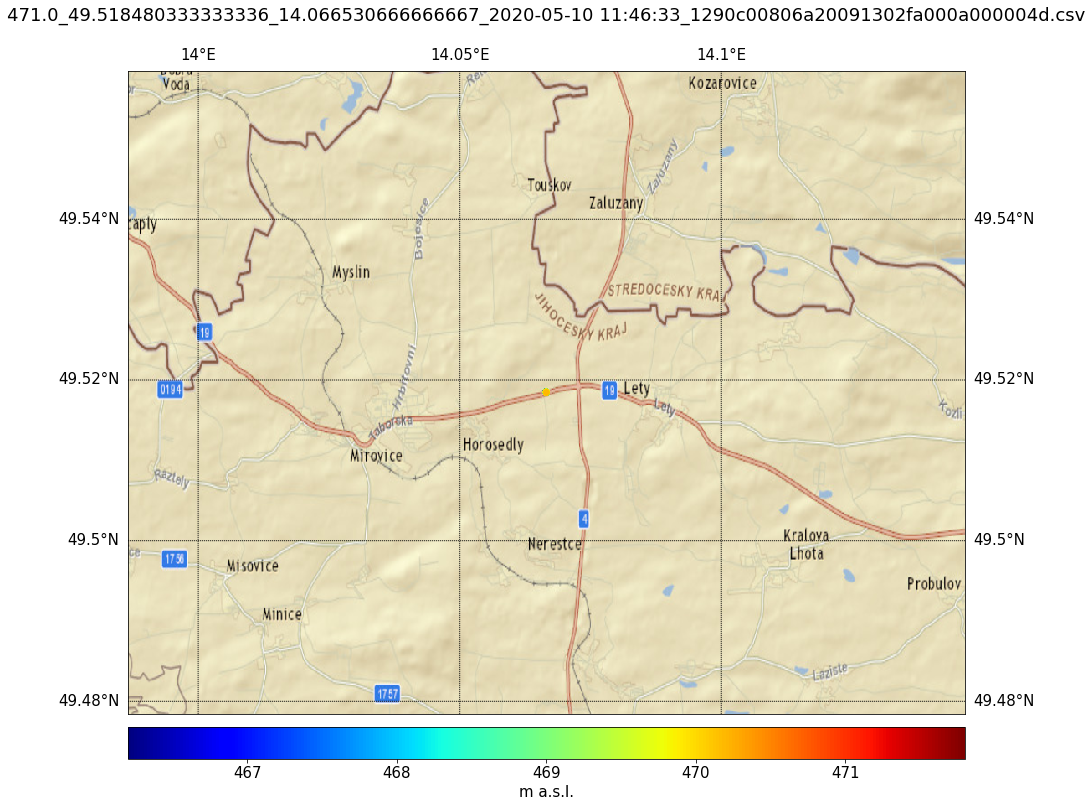

49.473811   14.658010500000001
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1622816.7056389956,6316315.817847883,1640627.8241659193,6329982.103812512&bboxSR=3395&imageSR=3395&size=1000,767&dpi=96&format=png32&transparent=true&f=image


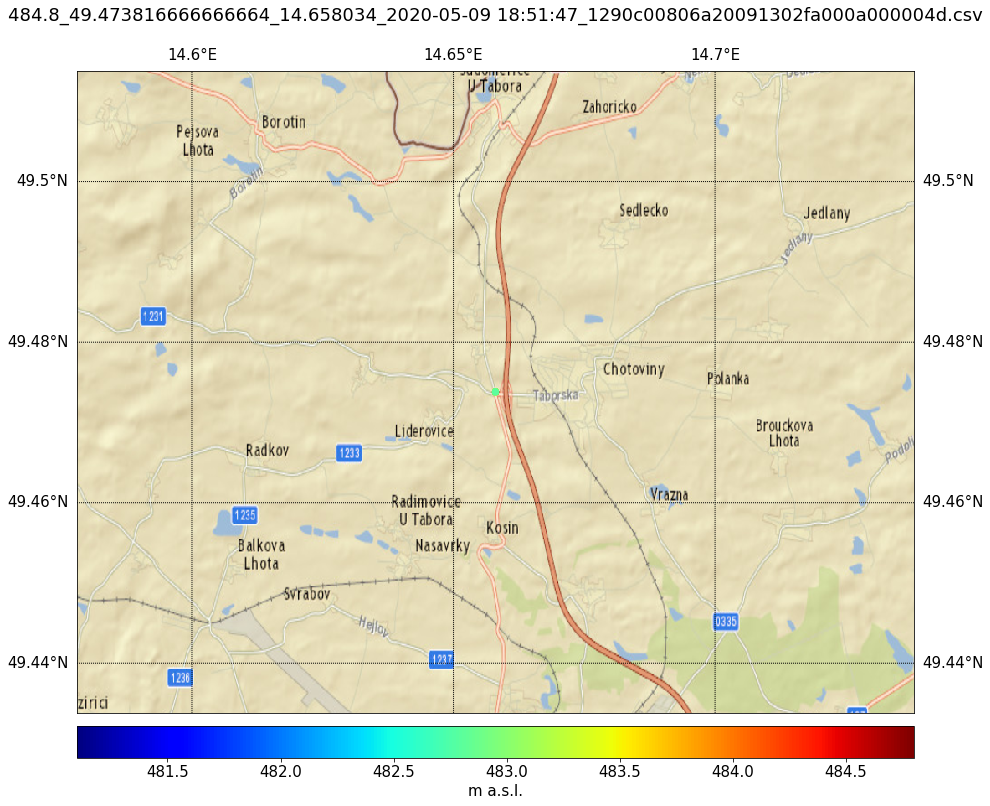

49.17523   14.677353333333333
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1624969.939996161,6265506.651471893,1642781.0585230847,6279089.847068661&bboxSR=3395&imageSR=3395&size=1000,762&dpi=96&format=png32&transparent=true&f=image


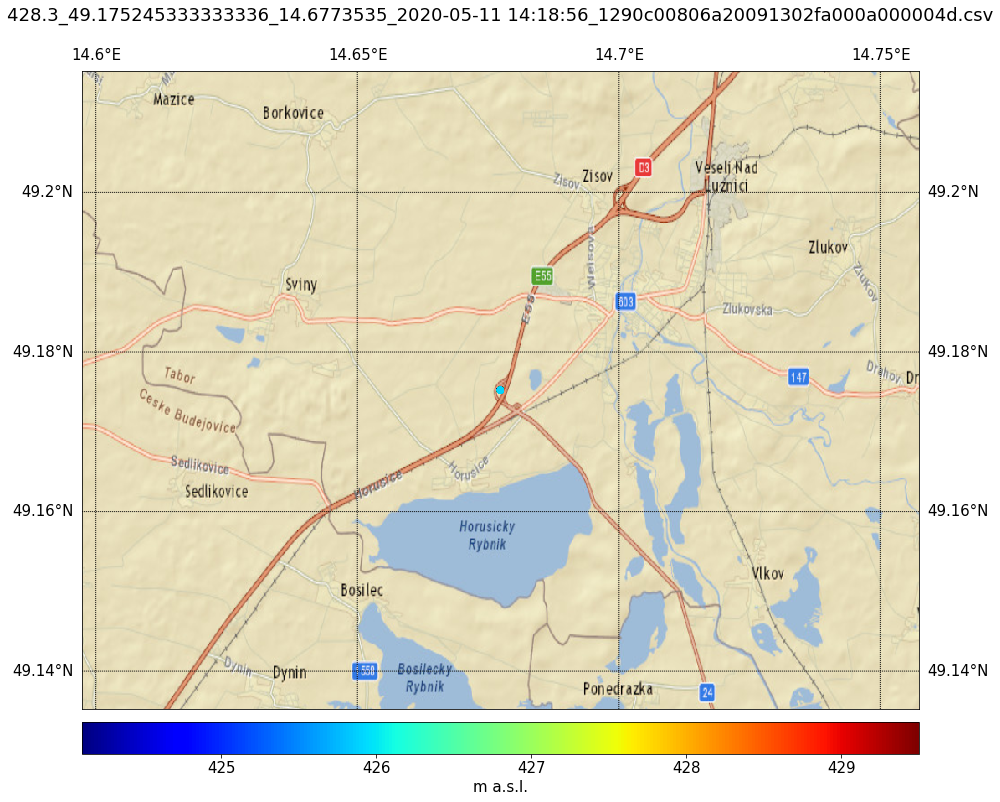

49.5824115   14.072041666666667
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1557586.9534916002,6334873.340560405,1575398.072018524,6348570.191950646&bboxSR=3395&imageSR=3395&size=1000,769&dpi=96&format=png32&transparent=true&f=image


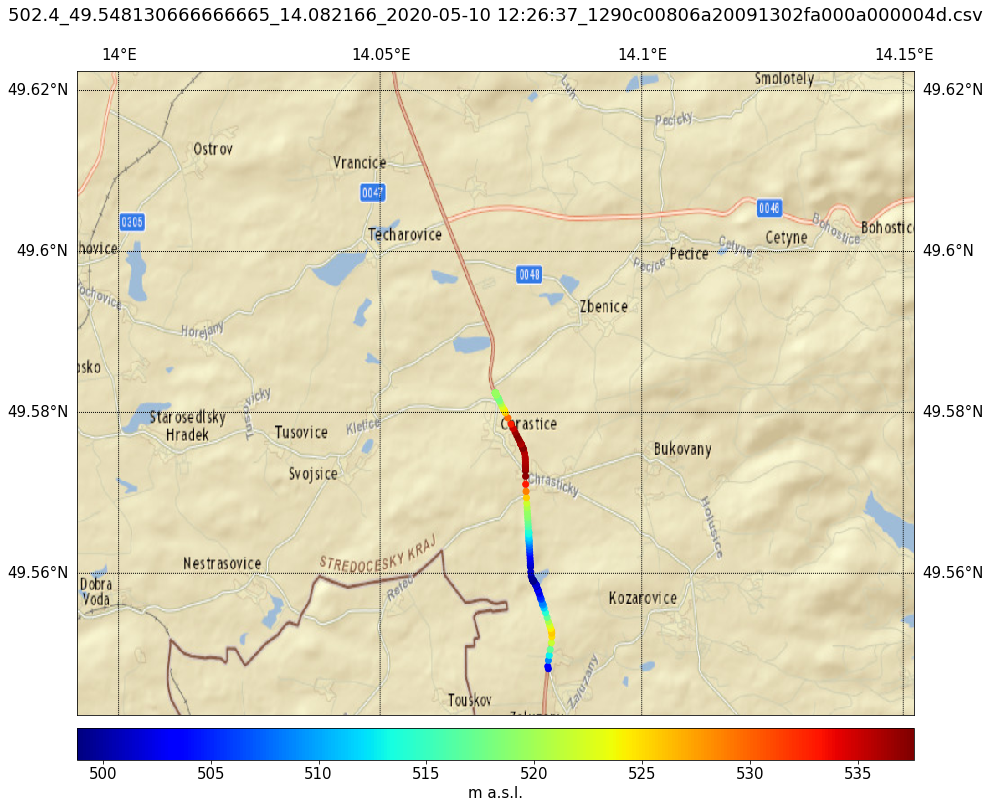

In [259]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os
import matplotlib

matplotlib.rcParams.update({'font.size': 15})

for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,15))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        #df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
        #df6.set_index('date', inplace = True)
        #df6 = df6.loc['2019-08-29 14:12':'2019-08-29 14:14']       
        print(float(df6['lat'].tail(1)), " ", float(df6['lon'].tail(1)))
               
        m = Basemap(llcrnrlon=df6['lon'][-1:]-0.08,llcrnrlat=df6['lat'][-1:]-0.04,urcrnrlon=df6['lon'][-1:]+0.08, urcrnrlat=df6['lat'][-1:]+0.04,  epsg = 3395,resolution='i',projection='merc')
        m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1000, verbose= True)
        x, y = m(df6.lon.tolist(),df6.lat.tolist())
        m.drawparallels(np.arange(0.,99.,0.02),labels=[1,1,0,0])
        m.drawmeridians(np.arange(0.,20.,0.05),labels=[0,0,1,0])        
        im1 = m.scatter(x,y,c=df6.altitude.tolist(),marker='o', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('m a.s.l.')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        plt.show() 
    except:
        pass


## Plot map with lightning

49.51844216666667   14.066562
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1543618.620893357,6313692.94978819,1588146.4172106665,6347890.067010913&bboxSR=3395&imageSR=3395&size=1000,767&dpi=96&format=png32&transparent=true&f=image


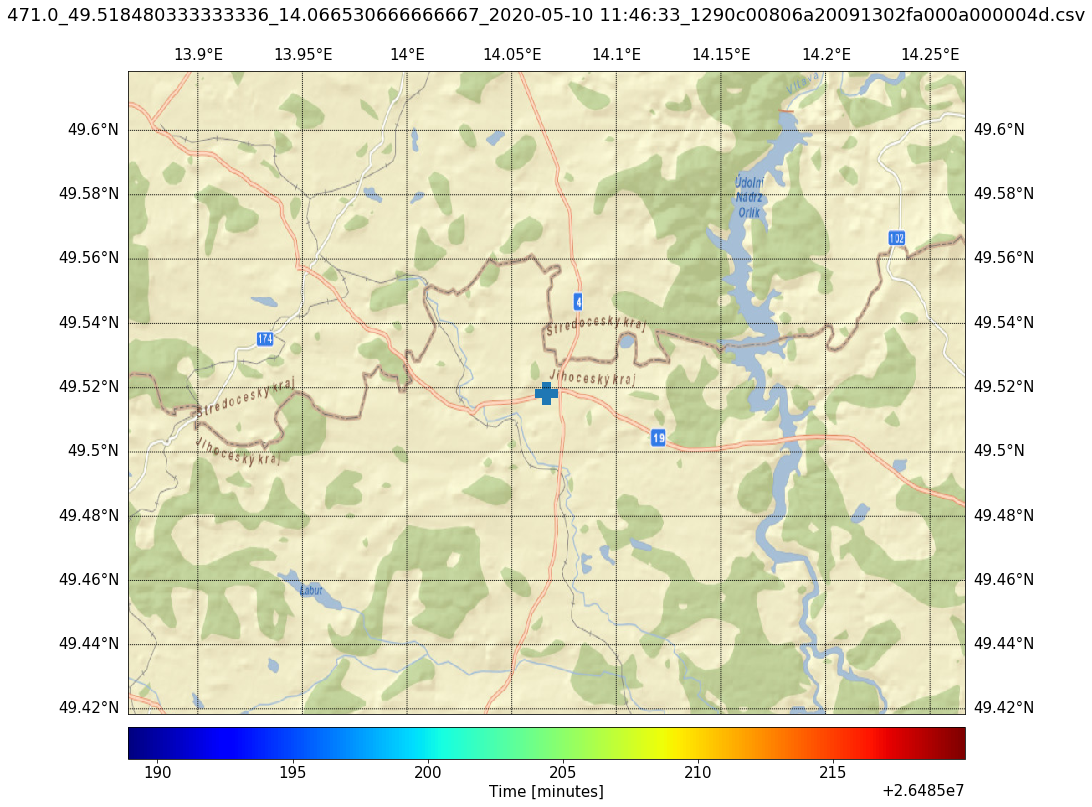

49.473811   14.658010500000001
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1609458.3667438028,6306080.807506641,1653986.163061112,6340246.577061089&bboxSR=3395&imageSR=3395&size=1000,767&dpi=96&format=png32&transparent=true&f=image
49.17523   14.677353333333333
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1611611.6011009684,6255333.717364113,1656139.3974182778,6289291.759839779&bboxSR=3395&imageSR=3395&size=1000,762&dpi=96&format=png32&transparent=true&f=image


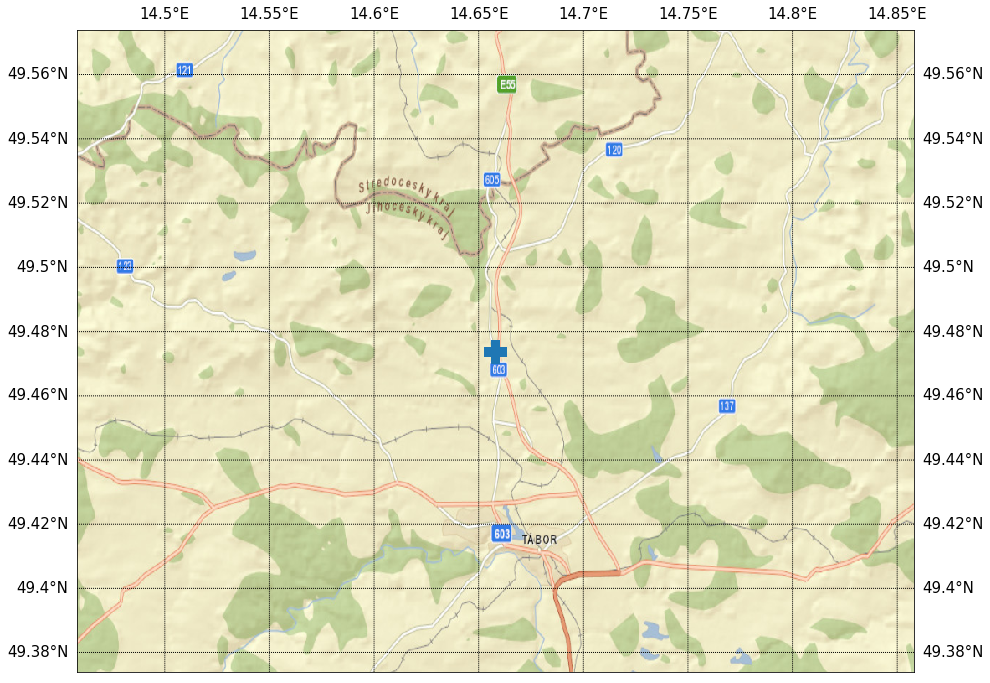

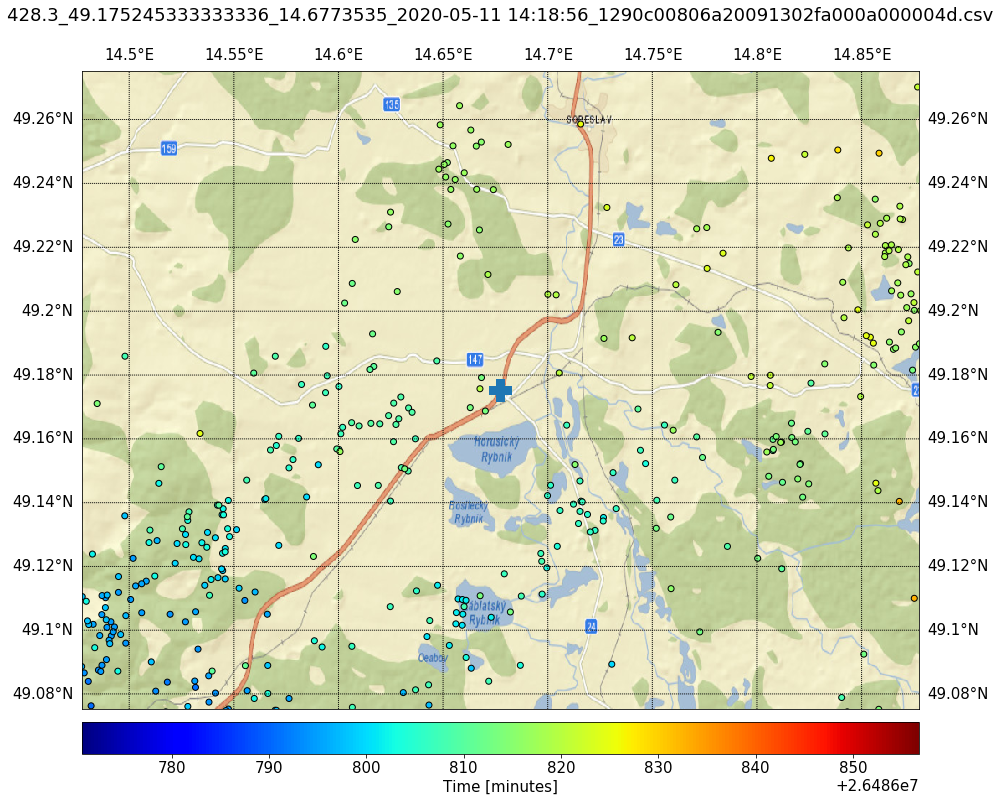

49.5824115   14.072041666666667
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1544228.6145964076,6324615.495298529,1588756.4109137168,6358857.678847232&bboxSR=3395&imageSR=3395&size=1000,769&dpi=96&format=png32&transparent=true&f=image


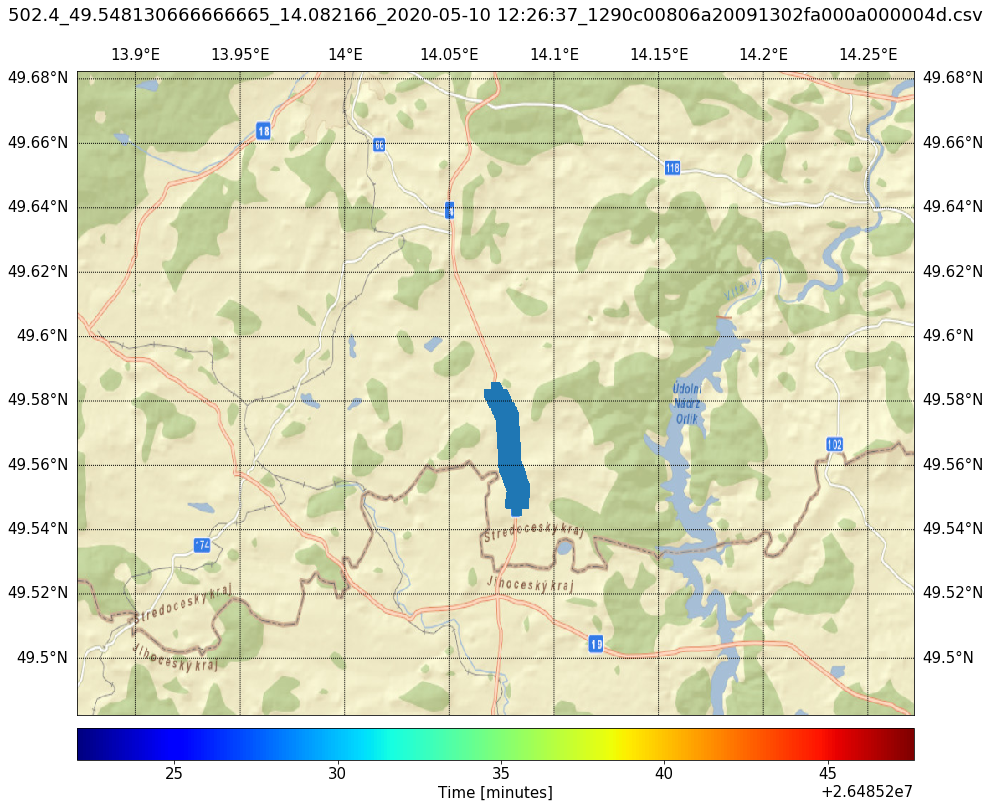

In [6]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os
import matplotlib

matplotlib.rcParams.update({'font.size': 15})

for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,15))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        #df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
        print(float(df6['lat'].tail(1)), " ", float(df6['lon'].tail(1)))
               
        m = Basemap(llcrnrlon=df6['lon'][-1:]-0.2,llcrnrlat=df6['lat'][-1:]-0.1,urcrnrlon=df6['lon'][-1:]+0.2, urcrnrlat=df6['lat'][-1:]+0.1,  epsg = 3395,resolution='i',projection='merc')
        m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1000, verbose= True)
        x, y = m(df6.lon.tolist(),df6.lat.tolist())
        m.drawparallels(np.arange(0.,99.,0.02),labels=[1,1,0,0])
        m.drawmeridians(np.arange(0.,20.,0.05),labels=[0,0,1,0])        
        im1 = m.scatter(x,y,marker='P', s = 500)

        df7 = pd.read_csv(f[:-3]+'blitz')
        x, y = m(df7.lon.tolist(),df7.lat.tolist())

        im1 = m.scatter(x,y,c=(df7.time/1000000000/60).tolist(),marker='o', edgecolors='black', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('Time [minutes]')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        plt.show() 
    except:
        pass


## Plot Map with speed for identifiing car movement

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1622829.1548687157,6316162.768674492,1640640.2733956394,6329828.8030422265&bboxSR=3395&imageSR=3395&size=800,613&dpi=96&format=png32&transparent=true&f=image


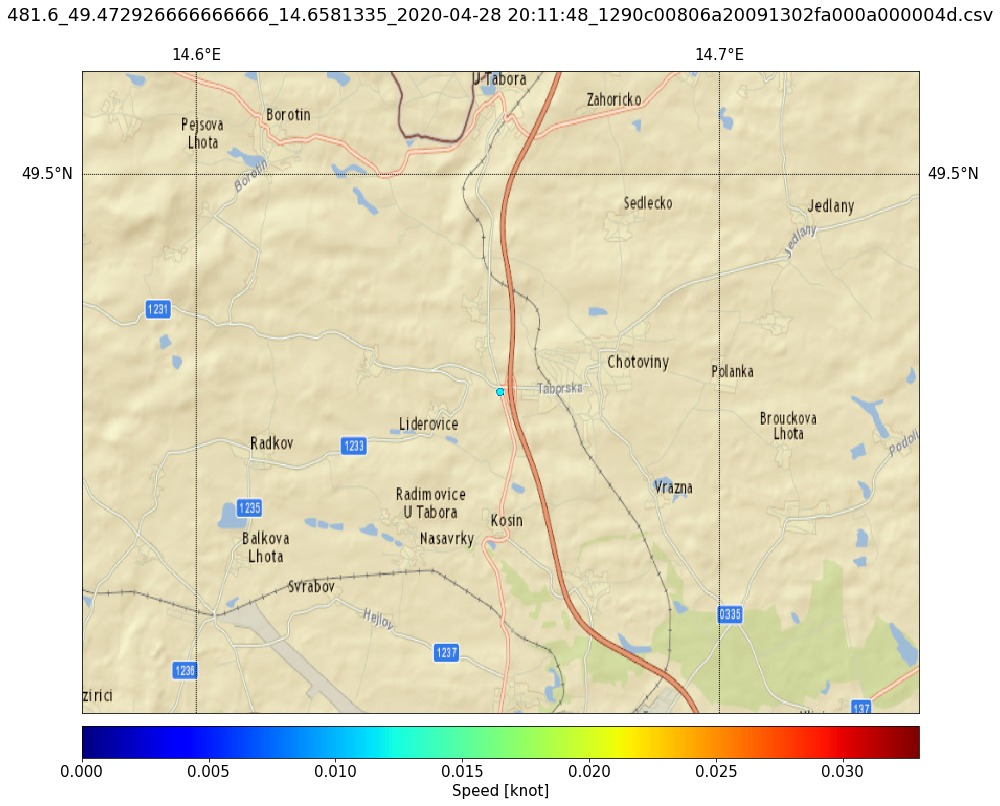

In [218]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,15))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        #df6.dropna(inplace=True)
        #df6.set_index('date', inplace = True)
        #df6 = df6.loc['2019-08-29 14:12':'2019-08-29 14:14']
        
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['speed'] = pd.to_numeric(df6['speed'])
               
        matplotlib.rcParams.update({'font.size': 15})

        m = Basemap(llcrnrlon=df6['lon'][-1:]-0.08,llcrnrlat=df6['lat'][-1:]-0.04,urcrnrlon=df6['lon'][-1:]+0.08, urcrnrlat=df6['lat'][-1:]+0.04,  epsg = 3395,resolution='i',projection='merc')
        #m = Basemap(llcrnrlon=14.36,llcrnrlat=50.24,urcrnrlon=14.38, urcrnrlat=50.25,  epsg = 3395,resolution='i',projection='merc')
        #m = Basemap(llcrnrlon=15.25,llcrnrlat=50.1,urcrnrlon=15.5, urcrnrlat=50.2, epsg = 31284)
 
        m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 800, verbose= True)

        x, y = m(df6.lon.tolist(),df6.lat.tolist())

        m.drawparallels(np.arange(0.,99.,0.1),labels=[1,1,0,0])
        m.drawmeridians(np.arange(0.,20.,0.1),labels=[0,0,1,0])
        
        im1 = m.scatter(x,y,c=df6.speed.tolist(),marker='o', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('Speed [knot]')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        plt.show() 
    except:
        pass


## Light Curves

In [199]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 

# Time difference of captured video and captured antenna data in seconds
TimeDilatationPlus = 60
TimeDilatationMinus = 60

dto = '/storage/experiments/' + storm_name  #  Directory to Open

for f in glob.iglob(dto + '/video/light/*.*.csv'): # generator, search immediate subdirectories 
    #try:
        s = f.split('/')
        st = s[len(s)-1]
        ss = st.split('.')
        sst = ss[0] + '.' + ss[1]

        y = pd.read_csv(f)

        for fa in glob.iglob(dto + '/osciloskop/csv/*.csv'): # generator, search immediate subdirectories 
            dfc = pd.read_table(fa, sep=',', skiprows=1, nrows=1, header=None, comment='*',engine='python' )
            sss = ss[0].split('_')
            diff = pd.to_datetime(sss[1] + sss[2], format='%Y-%m-%d%H-%M-%S')-pd.to_datetime(dfc[1])
            if (diff[0].seconds < TimeDilatationPlus)&(diff[0].seconds > -TimeDilatationMinus):
                dfa = pd.read_table(fa, sep=',', skiprows=13, header=None, comment='*',engine='python' )
                plt.figure(figsize=(15,5))
                plt.rc('font', size=16)    
                plt.rc_context({'ytick.color':'blue'})

                plt.plot(dfa[3]-2e-1,dfa[4],label='Antenna')

                plt.grid(b=True, which='major', color='grey', linestyle='-')
                plt.ylabel('dB/dt [~V]',color='blue')
                plt.xlabel('Time [s]')
                plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
                #plt.xlim(-0.2,0.20)
                #plt.xlim(-0.1175,-0.11)
                #plt.ylim(-0.07,0.07)

                dfb = dfa.rolling(window=30).mean()
                plt.plot(dfb[3]-2e-1,dfb[4], c='lightsteelblue', label="Rolling Mean")
                plt.legend(loc=2)

                plt.rc_context({'ytick.color':'red'})
                plt.twinx()

                plt.plot(np.linspace(-0.639,0.659,3900),y['0'], c='r', label='Camera',drawstyle='steps-post', alpha=0.5)
                #plt.plot(np.linspace(df[1],df[3],df[2]-df[0])+0.00066678,y.iloc[:int(df[2]-df[0]),1], c='r', label='camera',drawstyle='steps-post')
                #plt.plot(np.linspace(df[1],df[3],df[2]-df[0]),y.iloc[:int(df[2]-df[0]),1], c='r', label='camera')
                plt.yscale('log')
                plt.title(ss[0] + ' - ' + dfc[1][0])
                plt.xlabel('Time [s]')
                plt.ylabel('Illuminance [a.u.]',color='red')
                plt.legend(loc=1)
                #plt.ylim(8,25)
    #except:
    #    pass

In [200]:
dto = '/storage/experiments/' + storm_name  #  Directory to Open

for f in glob.iglob(dto + '/video/light/*.*.csv'): # generator, search immediate subdirectories 
    #try:
        s = f.split('/')
        st = s[len(s)-1]
        ss = st.split('.')
        sst = ss[0] + '.' + ss[1]

        y = pd.read_csv(f)
        frames = y.loc[y['0']==0].index[0]

        plt.figure(figsize=(15,5))

        plt.plot(np.linspace(-0.2,(1/2999)*frames-0.2,frames),y['0'][:frames])
        plt.yscale('log')
        plt.title(' Light Curve ' + st)
        plt.xlabel('Time [s]')
        plt.ylabel('Illuminance [a.u.]')
    #except:
    #    pass


In [203]:
matplotlib.rcParams.update({'font.size': 18})

for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    #try:
        s = f.split('/')

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$MPL'].index, inplace=True)
        
        #plt.figure(figsize=(40,40))
        #plt.tight_layout()
        
        fig, (ax1, ax5, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15,25))
        #fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(15,25))
        
        ax1.set_ylim(0,0)
        ax1.set_yticks([])
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==8]
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='stroke')
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==4]
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='spark')
        ax1.set_title(s[len(s)-1])
        #ax1.set_xlabel('UT')
        ax1.set_ylabel('Lightning')
        ax1.legend()
        ax1.grid()

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['3'] = pd.to_numeric(xx['3'])

        interval = '5T'
        xx = xx.resample(interval, label='right').sum()
        ax2.plot(xx['3'], drawstyle='steps-mid', label = interval + ' precipitation')
        #ax2.set_title(interval + ' - ' + s[len(s)-1])
        ax2.set_ylabel('Flips [-]')
        ax2.grid(b=True, which='major', color='grey', linestyle='-')
        ax2.locator_params(axis="y", integer=True, tight=True)
        ax2.legend()
        ax2.set_xlabel('UT')
        
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['4'] = pd.to_numeric(xx['4'])
        xx['5'] = pd.to_numeric(xx['5'])
        '''
        ax3.plot(xx['4'])
        #plt.locator_params(axis='y', nbins=6)
        ax3.grid(b=True, which='major', color='grey', linestyle='-')

        #ax3.set_title(s[len(s)-1])
        #ax3.set_xlabel('UT')
        ax3.set_ylabel('Pressure')
        #plt.legend(loc=2)

        ax4.plot(xx['5'])
        ax4.set_xlabel('UT')
        ax4.set_ylabel('Temperature')
        #plt.autoscale()       
        ax4.grid(b=True, which='major', color='grey', linestyle='-')
        #plt.grid(b=True, which='minor', color='grey', linestyle='-')
        #plt.legend()
        '''
        rto = '/storage/experiments/' + storm_name 
        d = read_rt_dat_file(rto + '/rt56#2/data.dat')
        import matplotlib.dates as md
        import matplotlib

        tmin = 1586779330
        tmax = 1586799330

        tmin = 1588105000
        tmax = 1588112654

        tmin = 1588613100
        tmax = 1588618290

        emin = 1
        emax = 1300

        nhits, time = np.histogram(d[(d['energy'] > emin) & (d['energy'] < emax)]['time'], tmax-tmin, [tmin, tmax])
        
        dfrt = pd.DataFrame(index=time[:-1],data=nhits)
        dfrt['time'] = pd.to_datetime(dfrt.index, unit='s')
        dfrt.reset_index(inplace=True)
        dfrt.set_index('time',inplace=True)
        dfrt['avg'] = dfrt[0].rolling(30).mean()

        ax5.set_ylabel('Counts ($s^{-1}$)')
        #ax5.plot_date(md.epoch2num(time[:-1]), nhits)
        ax5.plot(dfrt[0],ls='',alpha=130,marker='.',label='counts')
        ax5.plot(dfrt['avg'],lw=3,label='avg')

        ax5.set_ylim(350,770)
        #ax5.set_yscale('log')
        ax5.grid()
        ax5.legend()
        '''
        # For a file generated by Iva
        df = pd.read_csv('./data/data.csv', sep=',', header=0)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        df.set_index(df['timestamp'])
        ax5.plot(df['timestamp'],df['num_rec'], marker='.', linestyle='', label='RT Flux')
        df['avg'] = df['num_rec'].rolling(100).mean() 
        ax5.plot(df['timestamp'],df['avg'], label='RT Flux avg')
        #ax5.set_title('RT Flux')
        #ax5.set_xlabel('UT')
        ax5.set_ylabel(r'Counts [s$^-$$^1$]')
        ax5.grid()
        ax5.legend()
        '''
                
    #except:
        #pass



In [217]:
rto = '/storage/experiments/' + storm_name 
d = read_rt_dat_file(rto + '/RT/data.dat')
import matplotlib.dates as md
import matplotlib
from datetime import timezone


#tmin = 1586779330
#tmax = 1586799330

#tmin = 1588105000
#tmax = 1588112654

#tmin = 1588613100
#tmax = 1588618290

tmin = int(datetime(2020, 5, 11,14,25).replace(tzinfo=timezone.utc).timestamp())
tmax = int(datetime(2020, 5, 11,17,25).replace(tzinfo=timezone.utc).timestamp())

emin = 1
emax = 1300

nhits, time = np.histogram(d[(d['energy'] > emin) & (d['energy'] < emax)]['time'], tmax-tmin, [tmin, tmax])

dfrt = pd.DataFrame(index=time[:-1],data=nhits)
dfrt['time'] = pd.to_datetime(dfrt.index, unit='s')
dfrt.reset_index(inplace=True)
dfrt.set_index('time',inplace=True)
dfrt['avg'] = dfrt[0].rolling(30).mean()

plt.figure(figsize=(16, 10))
matplotlib.rcParams.update({'font.size': 15})

plt.ylabel('Counts ($s^{-1}$)')
plt.xlabel('UT')
#plt.plot_date(md.epoch2num(time[:-1]), nhits)
plt.plot(dfrt[0],ls='',alpha=130,marker='.',label='counts')
plt.plot(dfrt['avg'],lw=3,label='avg')
#plt.ylim(500,770)
plt.yscale('log')
plt.grid()
plt.legend()


TypeError: 'module' object is not callable

## Read log mlynek

In [ ]:
storm_name = '2020/04_mlynek_cinovec'
dto = '/storage/experiments/' + storm_name + '/' #  File to Open
fto = dto + 'DATALOG.TXT'

print (fto)

l = []
l.extend(range(0,20))
df = pd.read_table(fto, sep=',', header=None, comment='*', names=l, skiprows=0, nrows=100000 )
#df = pd.read_table(fto, sep=',', header=None,comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$TIME'].index, inplace=True)

In [ ]:
storm_name = '2020/04_mlynek_cinovec'
dto = '/storage/experiments/' + storm_name + '/' #  File to Open
fto = dto + 'DATALOG.TXT'

print (fto)

l=[]
l.extend(range(0,10))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*', skiprows=000000, nrows=1000000)

df['line'] = df.index
df['date'] = pd.to_datetime(df.loc[df[0]=='$GPRMC'][9].astype(str) + df.loc[df[0]=='$GPRMC'][1].astype(str), format='%d%m%y%H%M%S.%f',errors='coerce')
df['lineGPS'] = df.loc[df[0]=='$GPRMC']['line']
df['time'] = df.loc[df[0]=='$TIME'][1].astype(int)
df['line0'] = df.loc[df[0]=='$TIME']['line']
df = df.ffill(axis = 0)
df['time0'] = df.loc[(df[0]=='$TIME')&((df['line'] - df['lineGPS']) < 100)]['time']
df = df.ffill(axis = 0)

df.drop(df[df[0].str.contains('\$')].index, inplace=True) # delete $GPRMC a $TIME
df.drop(df.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9]], axis=1, inplace=True) # delete nan columns

df['timetime'] = pd.to_datetime(df['date'] +  pd.to_timedelta(df['time'] - df['time0'], unit='s') + pd.to_timedelta((df['line'] - df['line0']) * (87/1000), unit='s'))

df.set_index('timetime', inplace = True)
df.dropna(axis=0, how='any', inplace = True)
df[0] = df[0].astype(int)

plt.figure(figsize=(15,5))
plt.plot(df[0])
plt.ylim(-200,200)
plt.grid()
plt.ylabel('E field')
plt.xlabel('UT')
